In [1]:
### Cleaning up data ###
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv('data/AirQualityUCI.csv', sep=';')

# Create timestamps
df.insert(0, 'Timestamp', pd.to_datetime(df['Date'] + ' ' + df['Time'], format='%d/%m/%Y %H.%M.%S'))

# Drop useless columns
df = df.drop(['Unnamed: 15', 'Unnamed: 16', 'Date', 'Time'], axis=1)

# Columns to floats
for col in df.columns.drop('Timestamp'):
    df[col] = df[col].map(lambda x: float(str(x).replace(',', '.')))
    
# Add NaNs instead of 200
df = df.replace(-200, np.nan)

# Remove useless columns at end
df = df.loc[~pd.isnull(df['Timestamp']), :]

# Nice alternative dataframe with timestamps as index
df_ts = df.set_index('Timestamp', drop=True)

df.to_excel('output_data/cleaned.xlsx')

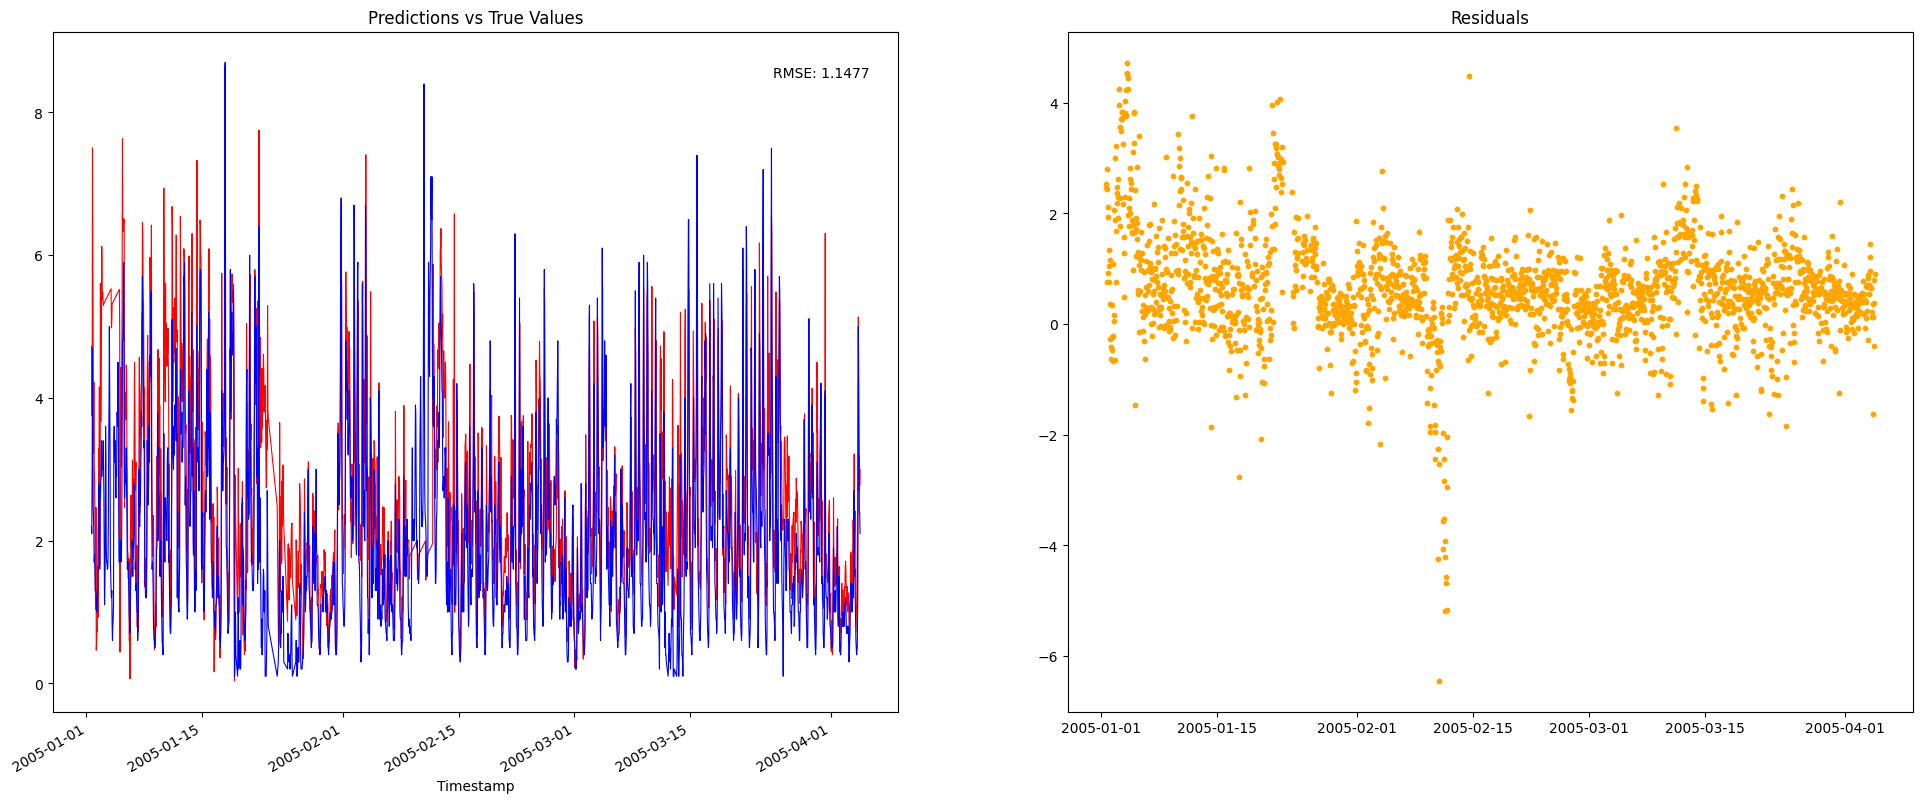

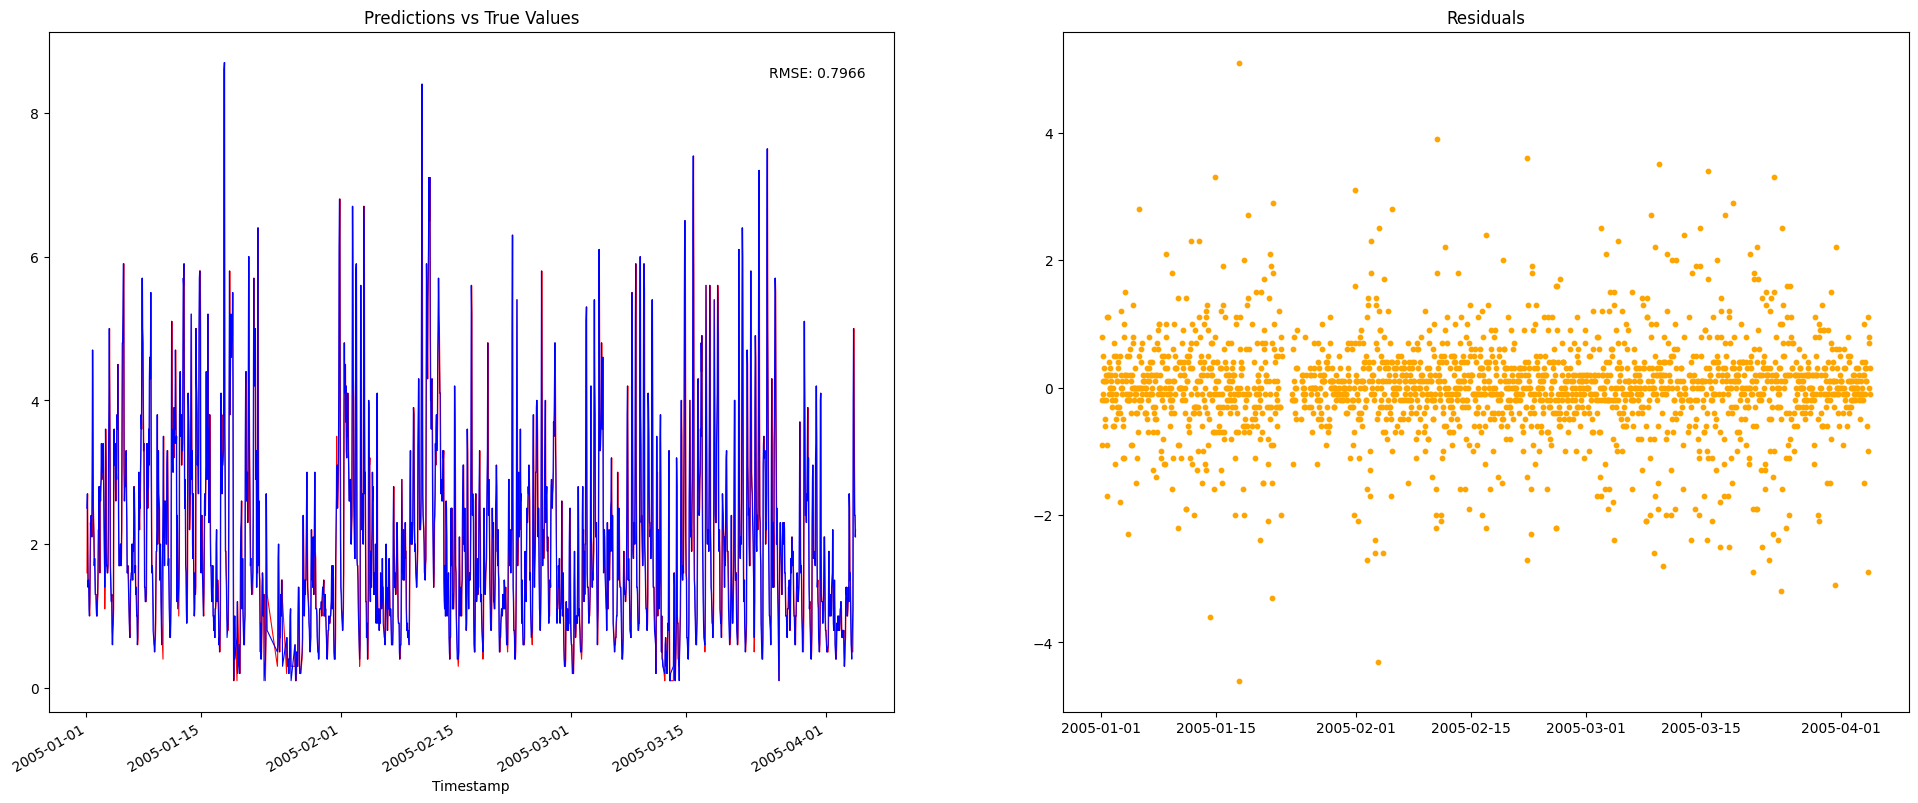

In [97]:

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler 
from collections import deque
from sklearn.metrics import root_mean_squared_error

# Impute missing ground truth data. This is purely an evaluation tool.

def get_train_test_validation(df_ts, *, target=None, validation=True):
    output_cols = ['CO(GT)', 'NMHC(GT)', 'NOx(GT)', 'NO2(GT)', 'C6H6(GT)']
    df_ts_input = df_ts.drop(output_cols, axis=1)
    df_ts_output = df_ts[output_cols]
    if target != None:
        df_ts_output = df_ts_output[[target]] 

    if not validation:
        df_train_X = df_ts_input[df_ts.index < '2005-01-01']
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2005-01-01']
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y 
    else:
        df_train_X = df_ts_input[df_ts.index < '2004-11-01']
        df_val_X = df_ts_input[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_X = df_ts_input[df_ts.index >= '2005-01-01']

        df_train_y = df_ts_output[df_ts.index < '2004-11-01']
        df_val_y = df_ts_output[(df_ts.index >= '2004-11-01') & (df_ts.index < '2005-01-01')]
        df_test_y = df_ts_output[df_ts.index >= '2005-01-01']
        
        return df_train_X, df_train_y, df_test_X, df_test_y, df_val_X, df_val_y 
        

target = 'CO(GT)'
df_train_X, df_train_y, df_test_X, df_test_y = get_train_test_validation(df_ts, target=target, validation=False)


class OnlineLinearModel:
    def __init__(self, hours_ahead_prediction):
        self.model = None
        self.shift = hours_ahead_prediction
        self.win_size = 15
        
    def feature_transform(self, train_X, is_live):
        train_X = train_X.copy()

        # interpolation
        if is_live:
            train_X = train_X.ffill() 
        else:
            train_X = train_X.interpolate(method='time') # plot this

        # normalisation
        if is_live:
            window = train_X.head(self.win_size)
            max_seen = window.max(axis=0)
            min_seen = window.min(axis=0)
            for i in range(len(train_X)):
                max_seen = max_seen.combine(train_X.iloc[i], np.maximum)
                min_seen = min_seen.combine(train_X.iloc[i], np.minimum)
                train_X.iloc[i] = (train_X.iloc[i] - min_seen) / (max_seen - min_seen)
        else:
            scaler = MinMaxScaler(copy=True)
            train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)
        

        # derived weekday, hour features
        train_X['hour'] = train_X.index.hour
        train_X['weekday'] = train_X.index.weekday

        # collapse to window. Keep timestamp of the latest item in the window
        final_X = self._window_to_row(train_X.head(self.win_size))
        for i in range(self.win_size + 1, len(train_X)-1):
            final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size+1:i])])
        train_X = final_X
        
        return train_X
    
    def _window_to_row(self, window : pd.DataFrame):
        """
        Takes a window and outputs a row of data for prediction of shift
        Assumes window is normalised
        """ 
        
        lags = 3
        new_cols = [f'{col} lag_{i}'for i in range(lags) for col in window.columns ]
        df = pd.DataFrame([window.tail(lags).to_numpy().flat], columns=new_cols, index=window.tail(1).index)
        
        return df
    
    def train(self, train_X, train_y):
        train_X = self.feature_transform(train_X, False)
        
        train_y = train_y.interpolate(method='time')
        
        prediction_idx = train_X.index + pd.Timedelta(hours=self.shift)
        train_X = train_X[prediction_idx.isin(train_y.index)]
        train_y = train_y[train_y.index.isin(prediction_idx)]
        

        self.model = LinearRegression().fit(train_X.to_numpy(), train_y.to_numpy()) 
        return self
    
    def predict(self, test_X):
        test_X = self.feature_transform(test_X, True)
        prediction_idx = test_X.index + pd.Timedelta(hours=self.shift)
        return pd.Series(self.model.predict(test_X.to_numpy()).flat, index=prediction_idx)

    # def train(self, train_X : pd.DataFrame, train_y : pd.DataFrame):
    #     train_X = train_X.copy()
    #     train_y = train_y.copy()
         
    #     # gap interpolation
    #     train_X = train_X.interpolate(method='time') # plot this
    #     train_y = train_y.interpolate(method='time')

    #     # normalisation
    #     scaler = MinMaxScaler(copy=True)
    #     train_X = pd.DataFrame(scaler.fit_transform(train_X), columns=train_X.columns, index=train_X.index)

    #     # derived weekday, hour features
    #     train_X['hour'] = train_X.index.hour
    #     train_X['weekday'] = train_X.index.weekday

    #     # create actual features
    #     final_X = self._window_to_row(train_X.head(self.win_size))
    #     for i in range(self.win_size + 1, len(train_X)-1):
    #         final_X = pd.concat([final_X, self._window_to_row(train_X.iloc[i-self.win_size:i-1])])
    #     train_X = final_X
        
    #     print(train_X)

    #     # apply shift
    #     train_y = train_y.shift(-self.shift)
    #     train_X.drop(train_X.tail(self.shift).index, axis=0, inplace=True)
    #     train_y.drop(train_y.tail(self.shift).index, axis=0, inplace=True)
    #     train_y.drop(train_y.head(self.win_size).index, axis=0, inplace=True)
        
    #     ## train model
    #     self.model = LinearRegression().fit(train_X.to_numpy(), train_y.to_numpy()) 

    #     return self
    
    # def predict(self, window, new_row):
    #     prediction_vec = self._window_to_row(window).to_numpy()
    #     return self.model.predict(prediction_vec)

    # def online_predict(self, test_X):
        
    #     # standard preprocess

    #     predictions = []
    #     window = test_X.head(self.win_size - 1)
    #     max_seen = window.max(axis=1).to_dict()
    #     min_seen = window.min(axis=1).to_dict()
    #     for i in range(self.win_size + 1, len(test_X)):
    #         row = test_X[i]
            
    #         # get new max/min
    #         for r in row.index:
    #             if (row[r] != np.nan):
    #                 max_seen[r] = max_seen(max[r], row[r])
    #                 min_seen[r] = min_seen(min[r], row[r])
    #                 row[r] = (row[r] - min_seen[r]) / (max_seen[r] - min_seen[r])

    #         window.concat(row, axis=0, inplace=True) 
    #         window.ffill()

    #         predictions.append(self.predict(window))

    #         window.drop([0], axis=0, inplace=True) 
        
    #     return np.array(predictions)


def evaluate(true, predictions):
    # normalise indices
    predictions = predictions[predictions.index.isin(true.index)]
    true = true[true.index.isin(predictions.index)]
    
    # plot
    fig, ax = plt.subplots(1, 2, figsize=(24, 10))
    
    predictions.rename('Predicted')
    true.rename('True')

    predictions.plot(linewidth=0.8, color='red', ax=ax[0])
    true.plot(linewidth=0.8, color='blue', ax=ax[0])
    ax[0].set_title('Predictions vs True Values')
    
    residuals = predictions - true
    ax[1].scatter(residuals.index, residuals.values, s=10, color='orange')
    ax[1].set_title('Residuals')
    
    rmse = root_mean_squared_error(true.to_numpy(), predictions.to_numpy())
    
    ax[0].text('2005-03-25', 8.5, f'RMSE: {rmse:.4f}')
    
lag = 1 
model = OnlineLinearModel(lag).train(df_train_X, df_train_y)
df_predict_y = model.predict(df_test_X)

true_values = df_test_y.dropna()[target]
naive_predictions = df_test_y.shift(lag).dropna()[target]

evaluate(true_values, df_predict_y)
evaluate(true_values, naive_predictions)

